In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from collections import defaultdict

sys.path.append(f"./../")
from src import SpaceEfficientVQF, Clause

In [3]:
# Load data from CSV
folder = f"./../data/biprimes/"
maxpow = 100  # 40

df = pd.read_csv(f"{folder}biprimes_maxpow_{maxpow}_number_200.csv")
biprimes = df["m=p*q"].to_list()
biprimes = [int(biprimes[i]) for i in range(len(biprimes))]

In [4]:
def binary_length_interval(numbers, min_length, max_length):
    selected_numbers = []
    for num in numbers:
        binary_repr = bin(num)[2:]  # Convert to binary and remove the '0b' prefix
        binary_length = len(binary_repr)
        if min_length <= binary_length <= max_length:
            selected_numbers.append(num)
    return selected_numbers

start = 20
end = 60
m_list = []
n_list = list(range(start, end, 10))

for i in range(len(n_list)):
    min_len = n_list[i] - 1
    max_len = n_list[i] + 1
    m = binary_length_interval(biprimes, min_len, max_len)
    m = max(m)
    m_list.append(m)
    print(m)

1687927
714433477
1753778247857
903873756190981


In [5]:
m_list = [int(m_list[i]) for i in range(len(m_list))]
markers = ["o", "s", "^", "D"]
colors = ["blue", "green", "red", "purple"]

In [6]:
# Initialize lists to store data for all m values
all_n_vars_list = []
all_comp_ratio_list = []

for idx, m in enumerate(m_list):
    vqf = SpaceEfficientVQF(m)
    n_vars_list = []
    comp_ratio_list = []

    # Use tqdm to show progress for the loop
    for c in tqdm(vqf.selected_clauses, desc=f"Processing m = {m}"):
        if c != 0:
            n_vars = len(c.pq_part.free_symbols)
            n_vars_list.append(n_vars)
            table = c.reduce_space().remove_carry_bits()
            comp_ratio = np.abs(table.calc_r())
            comp_ratio_list.append(comp_ratio)

    # Store the data for this m value
    all_n_vars_list.append(n_vars_list)
    all_comp_ratio_list.append(comp_ratio_list)

Processing m = 903873756190981: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


In [7]:
from src.clause_utils import get_tuples, keep_max_y_coordinate

def filter_data(x_list, y_list):
    data = set()
    tuples = get_tuples(x_list, y_list)
    data = data | tuples
    fdata = keep_max_y_coordinate(data)
    return fdata

data = filter_data(all_n_vars_list[1], all_comp_ratio_list[1])
data

{(2, 0.4150374992788439),
 (3, 1.0),
 (4, 0.8300749985576878),
 (5, 0.0),
 (6, 1.2451124978365318),
 (7, 0.0),
 (8, 1.6601499971153757),
 (9, 0.0),
 (10, 2.0751874963942187),
 (11, 0.0),
 (12, 2.4902249956730635),
 (13, 0.0),
 (14, 2.9052624949519075),
 (15, 0.0),
 (16, 3.3202999942307514)}

In [57]:
def scatter_and_linear_fit(x_list, y_list):
    tuples_set = filter_data(x_list, y_list)
    x = np.array([x for x, y in tuples_set])
    y = np.array([y for x, y in tuples_set])
    # Extract x and y coordinates from the set of tuples where x is even
    x_fit = np.array([x for x, y in tuples_set if x % 2 == 0])
    y_fit = np.array([y for x, y in tuples_set if x % 2 == 0])

    # Perform linear regression to get the slope (m) and intercept (b)
    m, b = np.polyfit(x_fit, y_fit, 1)

    # Draw the linear fit (regression line)
    plt.plot(
        x_fit,
        m * x_fit + b,
        '--',
        color="red",
        label=f"Linear Fit: {round(m, 2)} x + {round(b, 2)}",
        dashes=(2, 4)
    )

    plt.scatter(x, y)

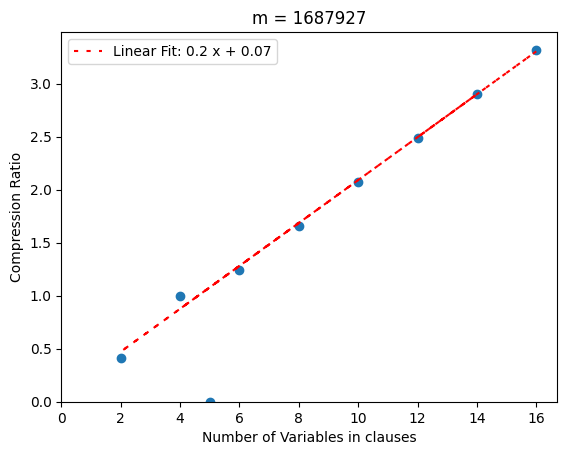

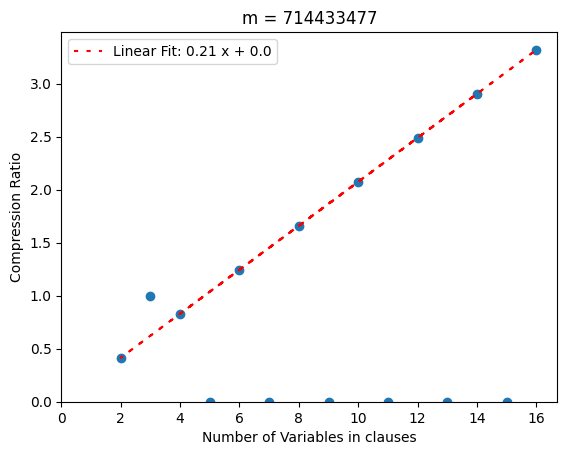

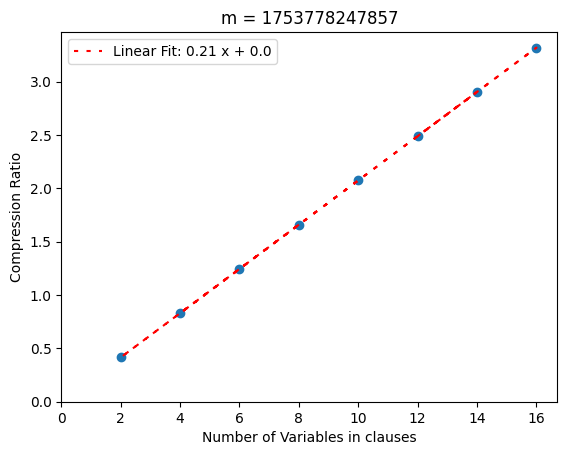

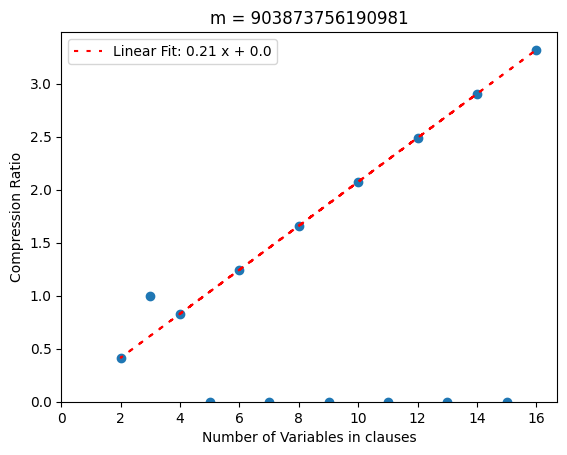

In [58]:
for i in range(len(m_list)):
    plt.cla()
    scatter_and_linear_fit(all_n_vars_list[i], all_comp_ratio_list[i])

    plt.xlim(0, None)
    plt.ylim(0, None)
    # Add labels and legend
    plt.xlabel("Number of Variables in clauses")
    plt.ylabel("Compression Ratio")
    # Add a title
    plt.title(f"m = {m_list[i]}")
    plt.legend()
    plt.savefig(f'./../data/figs/comp_ratios_{m_list[i]}.pdf')
    plt.show()